In [56]:
from google.colab import drive
drive.mount('/content/data')

Drive already mounted at /content/data; to attempt to forcibly remount, call drive.mount("/content/data", force_remount=True).


In [57]:
# 1. 랜덤 고정
import os
import numpy as np
import random
import torch

def reset_seeds(seed=42):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)    # 파이썬 환경변수 시드 고정
  np.random.seed(seed)
  torch.manual_seed(seed) # cpu 연산 무작위 고정
  torch.cuda.manual_seed(seed) # gpu 연산 무작위 고정
  torch.backends.cudnn.deterministic = True  # cuda 라이브러리에서 Deterministic(결정론적)으로 예측하기 (예측에 대한 불확실성 제거 )

In [149]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt

# EasuDict: 딕셔너리(dict)의 value를 속성(attribute)처럼 사용할 수 있게 함
import easydict
args = easydict.EasyDict()

plt.style.use('fivethirtyeight')
plt.ion()

warnings.filterwarnings('ignore')
args.data_csv = '/content/data/MyDrive/study/미니2/E Commerce Dataset (1).csv'
df_data = pd.read_csv(args.data_csv)

df_data.shape

(5630, 20)

In [150]:
import logging
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [170]:
# 중복 제거
def __remove_duplicant(df:pd.DataFrame) -> None:
    reset_seeds()
    print(f"before: {df.shape}")
    df.drop_duplicates(keep='first', inplace=True, ignore_index=True)
    print(f"after: {df.shape}")

In [171]:
# 데이터 분리
def split_data(df:pd.DataFrame) -> tuple:
  reset_seeds()
  train, test  = train_test_split(df, test_size=0.7, stratify=df['Churn'])
  return train, test

In [172]:
# test data feature/target 분리
def split_target_feature(test):
  features = test.drop("Churn", axis=1)
  targets = test["Churn"]
  return features, targets

In [173]:
# 결측치 제거
def __fill_na(train:pd.DataFrame, test:pd.DataFrame) -> None:
  reset_seeds()
  # 결측치 컬럼 추출
  train_cols = train.isnull().sum()[train.isnull().sum()>0].index.tolist()
  test_cols = test.isnull().sum()[test.isnull().sum()>0].index.tolist()
  none_cols = list(set(train_cols) | set(test_cols))

  # 결측치 처리
  for col in none_cols:
    try:
      _value = train[col].median() # 수치형
    except:
      _value = train[col].mode().values[0] # 범주형은 최빈값으로 채우기
    finally:
      train[col].fillna(_value, inplace=True)
      test[col].fillna(_value, inplace=True)

In [174]:

# 필요없는 column 제거
def drop_cols(df:pd.DataFrame ,cols:list=['CustomerID']) -> None:
  reset_seeds()
  df.drop(cols, axis=1, inplace=True)

In [175]:

def do_cleaning_data(train:pd.DataFrame, test:pd.DataFrame) -> tuple:
  reset_seeds()

  # 행(row) 중복 데이터 제거
  __remove_duplicant(train)
  __remove_duplicant(test)

  # 필요없는 컬럼 제거
  drop_cols(train)
  drop_cols(test)

  # 결측치 제거
  __fill_na(train,test)

  return train, test

In [188]:
def new_features(df:pd.DataFrame):
    reset_seeds()
    #df['ActivityScore'] = (df['OrderCount'] * 0.4 + df['HourSpendOnApp'] * 0.3 + df['CouponUsed'] * 0.3)
    #df['OrderFrequency'] = df['OrderCount'] / (df['Tenure'] + 1)
    #df['CustomerValueScore'] = (df['CashbackAmount'] * 0.5 + df['OrderCount'] * 0.3 + df['Tenure'] * 0.2)
    #df['CityTier']= df['CityTier'].astype('category')
    df['Complain']= df['Complain'].astype('category')
    df['SatisfactionScore']= df['SatisfactionScore'].astype('category')
    return df

In [177]:
def label_encoding(train:pd.DataFrame, test:pd.DataFrame) -> tuple:
  reset_seeds()
  enc_cols = train.select_dtypes(exclude=np.number).columns.tolist()
  non_enc_cols = list(set(test.columns) - set(enc_cols))
  le = LabelEncoder()
  # encoding 결과 저장할 dataframe 선언
  enco_tr = pd.DataFrame()
  enco_te = pd.DataFrame()
  for col in enc_cols:
        enco_tr[col] = le.fit_transform(train[col])
        enco_te[col] = le.fit_transform(test[col])
  # Encoding 안한거랑 합치기
  train = pd.concat([train[non_enc_cols],enco_tr], axis=1)
  test = pd.concat([ test[non_enc_cols], enco_te], axis=1)
  return train, test

In [189]:
train, test = split_data(df_data)
train, test = do_cleaning_data(train, test)
train, test = new_features(train), new_features(test)

before: (1689, 20)
after: (1689, 20)
before: (3941, 20)
after: (3941, 20)


,Churn,Tenure,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,NumberOfAddress,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount,ActivityScore,OrderFrequency,CustomerValueScore
Churn,1.000000,-0.351812,0.059944,0.006418,0.108908,0.073441,-0.018532,0.026294,-0.003491,-0.133757,-0.139628,0.007554,0.372380,-0.156802
Tenure,-0.351812,1.000000,-0.029087,0.009067,-0.001880,0.231682,0.012999,0.090446,0.158847,0.169065,0.485011,0.144879,-0.414004,0.534892
WarehouseToHome,0.059944,-0.029087,1.000000,0.081508,-0.013592,0.006531,-0.006144,-0.007163,-0.029056,0.012919,0.010000,-0.012486,0.006192,0.006632
HourSpendOnApp,0.006418,0.009067,0.081508,1.000000,0.310868,0.172530,0.069918,0.182953,0.114078,0.042824,0.124154,0.273537,0.003817,0.123011
NumberOfDeviceRegistered,0.108908,-0.001880,-0.013592,0.310868,1.000000,0.096891,0.028837,0.138595,0.093279,0.004029,0.178295,0.154394,0.019621,0.173274
NumberOfAddress,0.073441,0.231682,0.006531,0.172530,0.096891,1.000000,0.011420,0.042563,0.016277,-0.068501,0.175248,0.048634,-0.119076,0.183268
OrderAmountHikeFromlastYear,-0.018532,0.012999,-0.006144,0.069918,0.028837,0.011420,1.000000,0.035800,0.034058,0.009740,-0.003252,0.045572,0.004627,-0.001088
CouponUsed,0.026294,0.090446,-0.007163,0.182953,0.138595,0.042563,0.035800,1.000000,0.660677,0.302791,0.200372,0.839341,0.318890,0.219711
OrderCount,-0.003491,0.158847,-0.029056,0.114078,0.093279,0.016277,0.034058,0.660677,1.000000,0.413562,0.317528,0.951325,0.364399,0.347614
DaySinceLastOrder,-0.133757,0.169065,0.012919,0.042824,0.004029,-0.068501,0.009740,0.302791,0.413562,1.000000,0.304909,0.403201,0.161391,0.316372


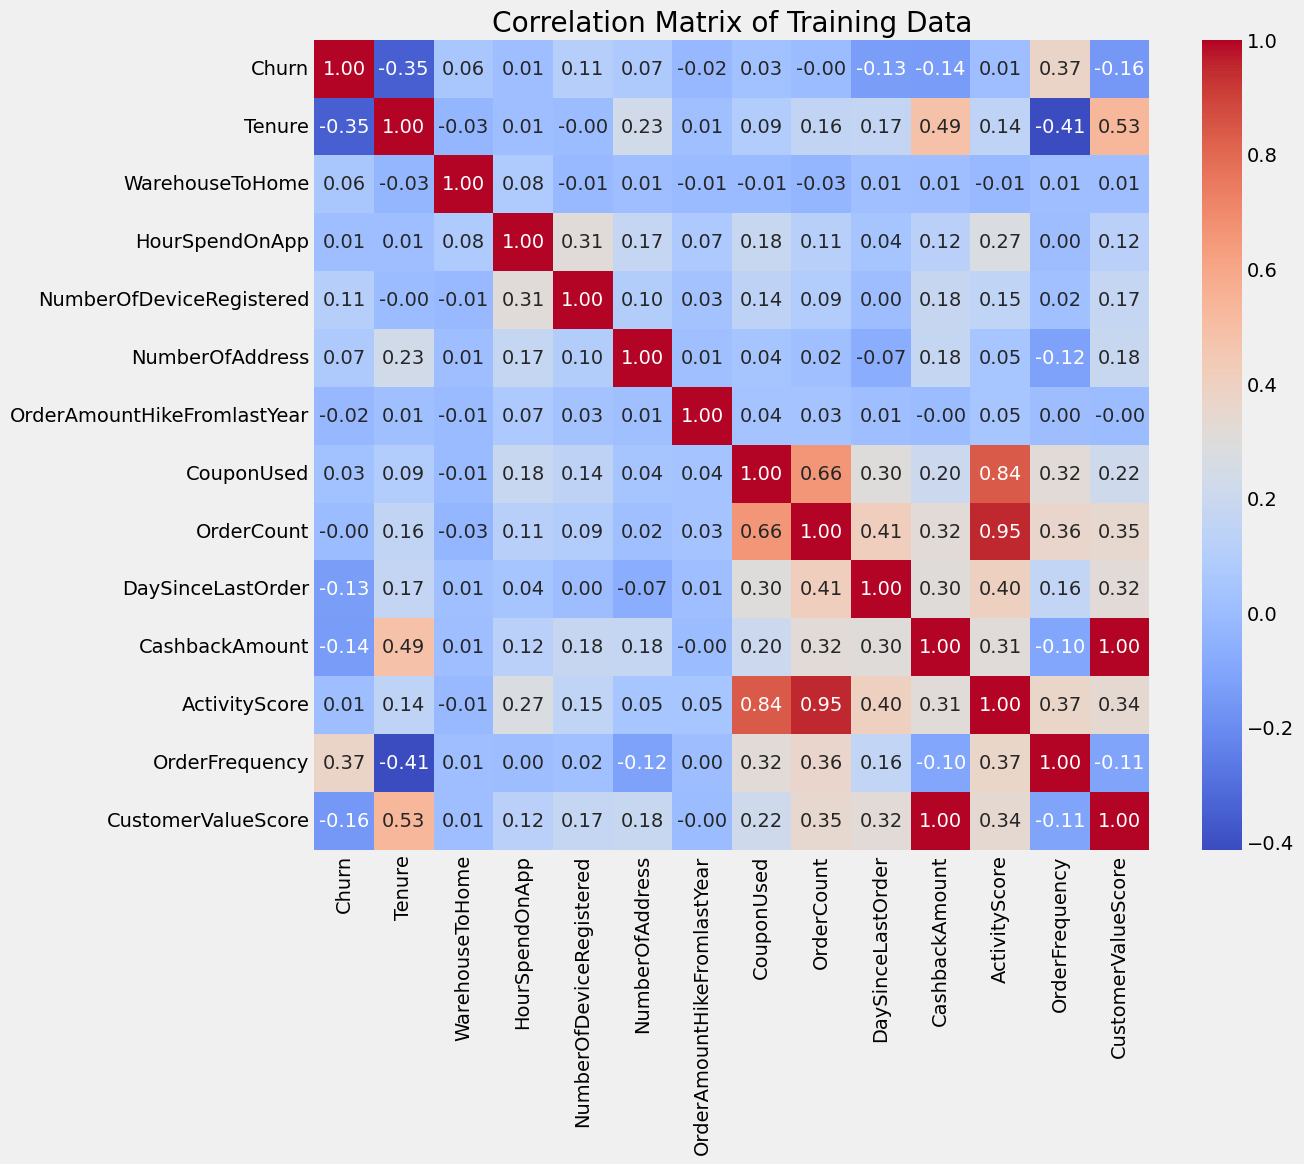

In [190]:
# Calculate the correlation matrix
correlation_matrix = train.corr(numeric_only=True)

# Display the correlation matrix
display(correlation_matrix)


import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Training Data')
plt.show()

In [191]:
enco_train, enco_test = label_encoding(train,test)
train_features, train_target =split_target_feature(enco_train)
test_features, test_target = split_target_feature(enco_test)
train_features.head()

,DaySinceLastOrder,WarehouseToHome,CouponUsed,HourSpendOnApp,ActivityScore,Tenure,OrderFrequency,OrderCount,NumberOfAddress,CustomerValueScore,...,OrderAmountHikeFromlastYear,NumberOfDeviceRegistered,PreferredLoginDevice,CityTier,PreferredPaymentMode,Gender,PreferedOrderCat,SatisfactionScore,MaritalStatus,Complain
0,10.0,6.0,4.0,2.0,5.0,26.0,0.296296,8.0,8,99.6,...,20.0,3,1,2,3,0,2,4,2,0
1,0.0,8.0,1.0,2.0,1.3,28.0,0.034483,1.0,9,150.9,...,12.0,4,1,0,3,1,5,4,1,0
2,2.0,7.0,1.0,3.0,1.6,2.0,0.333333,1.0,9,82.2,...,12.0,1,0,0,4,1,2,2,2,1
3,7.0,14.0,1.0,2.0,1.3,8.0,0.111111,1.0,2,62.4,...,16.0,4,0,0,0,0,2,3,1,1
4,9.0,33.0,3.0,4.0,2.9,16.0,0.117647,2.0,7,133.8,...,15.0,4,0,2,5,0,1,3,0,0


In [192]:
from lightgbm import LGBMClassifier, plot_importance

In [193]:
reset_seeds()

In [194]:
model = LGBMClassifier(verbose=-1)

In [195]:
from sklearn.metrics import roc_auc_score

In [196]:
from sklearn.model_selection import StratifiedKFold

reset_seeds()

cv = StratifiedKFold(n_splits=5, shuffle=True)

In [197]:
from sklearn.metrics import roc_auc_score
reset_seeds()

for i, (train_index, valid_index) in enumerate(cv.split(train_features, train_target)):
  # 학습용 데이터 -> features, targets
  tr_features, tr_targets = train_features.iloc[train_index], train_target.iloc[train_index]
  # 평가용 데이터 -> features, targets
  te_features, te_targets = train_features.iloc[valid_index], train_target.iloc[valid_index]

  # 모델 학습
  model.fit(tr_features, tr_targets)

  # 평가
  predictions = model.predict_proba(te_features)[:,1]
  predictions_tr = model.predict_proba(tr_features)[:,1]
  score = roc_auc_score(te_targets, predictions)
  score1 = roc_auc_score(tr_targets, predictions_tr)
  print(f"{i+1}번째 점수는 train {score1} test {score}")

1번째 점수는 train 1.0 test 0.9415620902790784
2번째 점수는 train 0.9999999999999999 test 0.9157145532871324
3번째 점수는 train 1.0 test 0.934319785228195
4번째 점수는 train 1.0 test 0.9353187238559031
5번째 점수는 train 1.0 test 0.9119217081850535


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

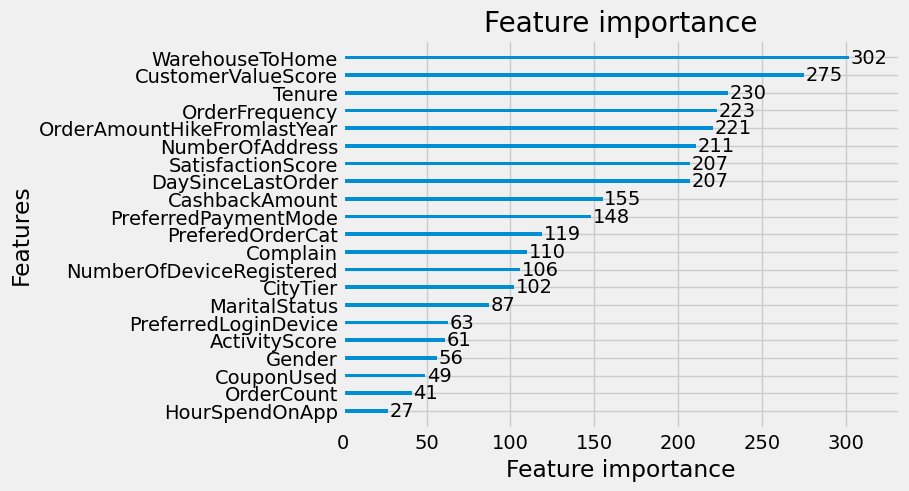

In [129]:
plot_importance(model)

In [130]:
!pip install shap

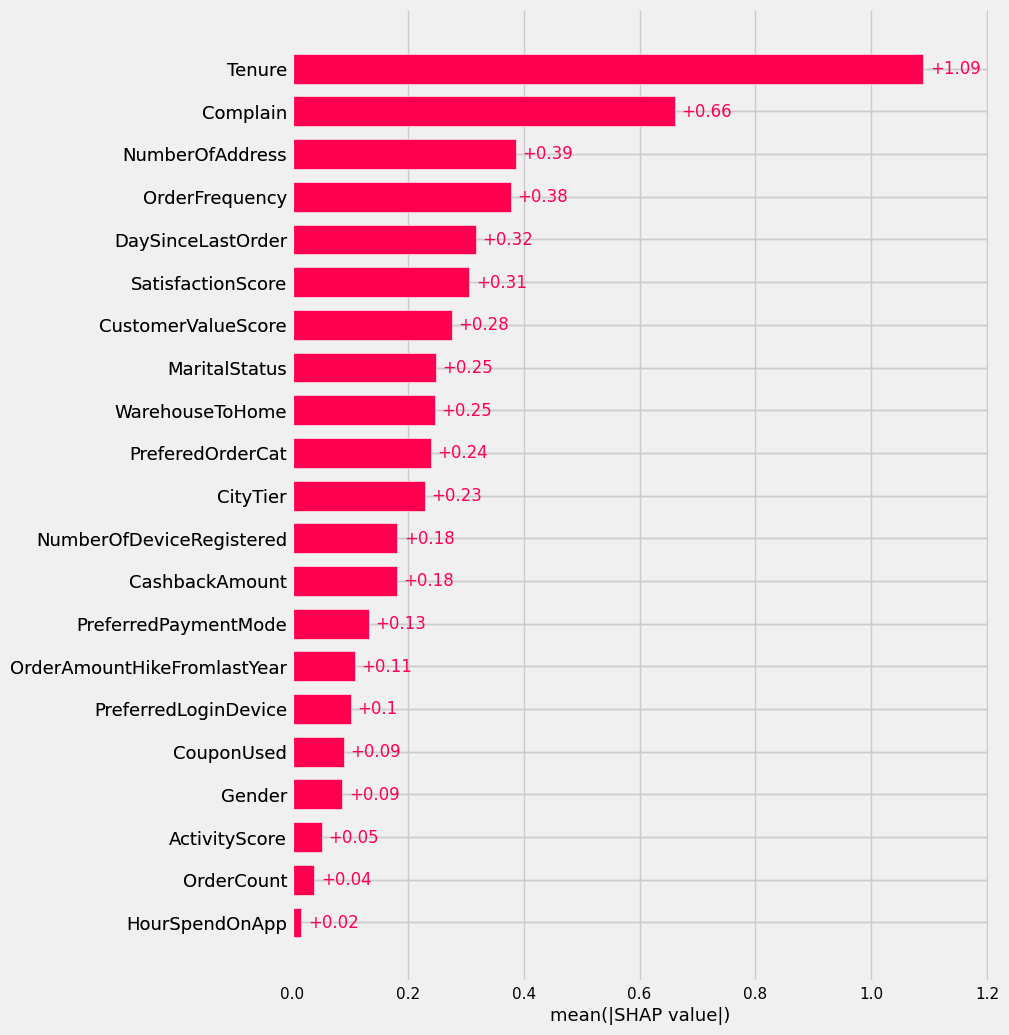

In [131]:
import shap
reset_seeds()
explainer = shap.Explainer(model)
shap_values = explainer(te_features)
shap.plots.bar(shap_values, max_display=te_features.shape[0])

In [198]:
predictions = model.predict_proba(test_features)[:,1]
score = roc_auc_score(test_target, predictions)
score

np.float64(0.9414337239099821)